# Artists

Let's take a look at the artists that have songs in the top charts. Are the most popular artists' songs in the top charts different from the less popular artists' songs?

In [1]:
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt

pp = pprint.PrettyPrinter(indent=4)

## Setup

To reduce the amount of data I need to process, I first dropped rows with NaNs and duplicates (determined by the song's unique ID/uri) and created a dataframe that only contains a single instance of each song. Then, to preserve information about how many days each song stayed on the top charts, I got counts of how many times each song occurs in the original dataset (which represents the number of days the song appeared on the top charts) and added that to the new dataframe

In [2]:
all_df = pd.read_csv("data/TopCharts_complete.csv").dropna()
df = all_df.drop_duplicates(subset = ['uri']).copy()
days_count = all_df.pivot_table(index = ['uri'], aggfunc='size')
for uri in days_count.index:
    df.loc[df.uri == uri, 'days'] = days_count[uri]
df.head()

rank        date            artist                                title  \
0     1  2017-01-01             Migos  Bad and Boujee (feat. Lil Uzi Vert)   
1     2  2017-01-01             Drake                            Fake Love   
2     3  2017-01-01        The Weeknd                              Starboy   
3     4  2017-01-01  The Chainsmokers                               Closer   
4     5  2017-01-01      Rae Sremmurd                        Black Beatles   

     streams  danceability  energy   key  loudness  mode  speechiness  \
0  1,371,493         0.927   0.665  11.0    -5.313   1.0       0.2440   
1  1,180,074         0.928   0.481   9.0    -9.350   0.0       0.2870   
2  1,064,351         0.679   0.587   7.0    -7.015   1.0       0.2760   
3  1,010,492         0.748   0.524   8.0    -5.599   1.0       0.0338   
4    874,289         0.794   0.632   0.0    -6.163   1.0       0.0649   

   acousticness  instrumentalness  liveness  valence    tempo  \
0         0.061          0.000000     0.123    0.175  127.076   
1         0.105          0.000000     0.176    0.613  134.007   
2         0.141          0.000006     0.137    0.486  186.003   
3         0.414          0.000000     0.111    0.661   95.010   
4         0.142          0.000000     0.128    0.355  145.926   

                                    uri  duration_ms  time_signature   days  
0  spotify:track:4Km5HrUvYTaSUfiSGPJeQR     343150.0             4.0  429.0  
1  spotify:track:343YBumqHu19cGoGARUTsd     210937.0             4.0  455.0  
2  spotify:track:7MXVkk9YMctZqd1Srtv4MB     230453.0             4.0  464.0  
3  spotify:track:7BKLCZ1jbUBVqRi2FVlTVw     244960.0             4.0  536.0  
4  spotify:track:6fujklziTHa8uoM5OQSfIo     291893.0             4.0  240.0

In [3]:
df.to_csv("data/TopCharts_days.csv", index = False)

In [3]:
#cluster only on continuous features
cluster_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness','valence', 'tempo']

Since we are doing our analysis on the level of artists, not songs, let's aggregate the song data by artists. To do this, I'll group the songs by artist, take the median values for the audio features, and sum the days each song was on the top chart. In other words:  

    songs --> group by artist --> total number of days, median danceability, ..., median tempo

In [4]:
artist_dict = {'artist': [], 'days' : [], 'avg_days':[]}
a1 = {"median_" + c:[] for c in cluster_cols}
artist_dict.update(a1)
unique_artists = df.artist.unique()
for a in unique_artists:
    subset = df.loc[df.artist == a, :]
    total = subset['days'].sum()
    artist_dict['days'].append(total)
    artist_dict['avg_days'].append(total/len(subset))
    artist_dict['artist'].append(a)
    for k in cluster_cols:
        artist_dict['median_' + k].append(subset[k].median())

In [5]:
df_artist = pd.DataFrame(artist_dict)
df_artist.head()

artist    days   avg_days  median_danceability  median_energy  \
0             Migos  3227.0  76.833333               0.8365         0.6690   
1             Drake  6877.0  76.411111               0.7200         0.5370   
2        The Weeknd  2926.0  68.046512               0.5600         0.6110   
3  The Chainsmokers  2577.0  80.531250               0.6160         0.6285   
4      Rae Sremmurd  1147.0  76.466667               0.8030         0.6320   

   median_loudness  median_speechiness  median_acousticness  \
0          -5.6810             0.15400              0.07950   
1          -7.7055             0.17350              0.11600   
2          -7.0150             0.06410              0.13100   
3          -6.6005             0.04265              0.05865   
4          -5.1930             0.06490              0.05440   

   median_instrumentalness  median_liveness  median_valence  median_tempo  
0                 0.000000           0.1325          0.3505      137.4800  
1                 0.000002           0.1225          0.3525      118.9900  
2                 0.000023           0.1250          0.2520      119.8290  
3                 0.000000           0.1505          0.3980      104.4755  
4                 0.000001           0.1110          0.2640      131.9860

### Analysis: Top 50 (most popular) artists vs bottom 50 (least popular) artists

Let's compare the top 50 most popular artists (by aggregate number of days on top charts) to bottom 50 artists.

In [6]:
#split clustered dataset into top 50 vs non top 50
top50 = df_artist.sort_values(by = 'days', ascending = False).iloc[:50, :]
bot50 = df_artist.sort_values(by = 'days', ascending = True).iloc[:50, :]

These are the top 50 artists with the largest total number of days on the top charts.

In [7]:
top50.loc[:, ['artist', 'days']].head()

artist     days
60     Post Malone  10513.0
171   XXXTENTACION   7221.0
1            Drake   6877.0
521  Billie Eilish   5180.0
141         Khalid   5066.0

In [8]:
bot50.loc[:, ['artist', 'days']].head()

artist  days
546                Ronny J   1.0
352          WALK THE MOON   1.0
360           Stevie Nicks   1.0
361     Lin-Manuel Miranda   1.0
364  Red Hot Chili Peppers   1.0

In [9]:
from scipy.stats import ttest_ind

Let's run some two-sample hypothesis tests on the median audio feature values to see if the top 50 artists' songs are different from the bottom 50 artists' songs. For example, suppose we want to run a test on median tempo:
* Let $med\_temp_{i}$ denote the median tempo of the $i^{th}$ artists' songs.
* Let $\bar{TEMP}_{k}$ denote the median tempo of artists' songs in the $k^{th}$ averaged across all artists in that group. Let $k=1$ be the group containing the top 50 artists, and $k=2$ be the group containing the bottom 50 artists.
* Similarly, let $s_{k}$ denote the standard deviation for the $k^{th}$ group, and let $n_k$ denote the number of artists in the $k^{th}$ group
* Then:
    * $H_0: \bar{TEMP_{1}} = \bar{TEMP}_{2}$
    * $H_1: \bar{TEMP}_{1} \neq \bar{TEMP}_{2}$
    * $T = \frac{\bar{TEMP_{1}} - \bar{TEMP}_{2}}{\sqrt{\frac{s_1^2}{n_1}+\frac{s_2^2}{n_2}}}$  
    
This is the general form each test will take. Since we are running 8 simultaneous tests (1 for each audio feature) at $\alpha = .05$, we need to control the false-positive rate. To do this, we will apply a simple Bonferroni correction such that $\alpha_{adjusted} = .05/8 = 0.00625$

In [10]:
alpha = .05/8
print(f"bonferroni-corrected alpha = .05/8 = {alpha}\n")
for col in top50.columns[3:11]:
    print(f"difference in... average {col}")
    print(f"\th0: Group 1 average {col} == Group 2 average {col}")
    print(f"\th1: Group 1 average {col} != Group 2 average {col}\n")
    print(f"\tGroup 1: {top50[col].mean()}\t\t\t Group 2:{bot50[col].mean()}")
    tt = ttest_ind(top50[col], bot50[col], equal_var = False)
    print(f"\tt = {tt[0]}")
    print(f"\tp = {tt[1]}")
    print(f"\tsignificant: {tt[1]<=alpha}\n")

bonferroni-corrected alpha = .05/8 = 0.00625

difference in... average median_danceability
	h0: Group 1 average median_danceability == Group 2 average median_danceability
	h1: Group 1 average median_danceability != Group 2 average median_danceability

	Group 1: 0.71203			 Group 2:0.6075200000000002
	t = 4.240610454707632
	p = 6.161498448531702e-05
	significant: True

difference in... average median_energy
	h0: Group 1 average median_energy == Group 2 average median_energy
	h1: Group 1 average median_energy != Group 2 average median_energy

	Group 1: 0.6035800000000001			 Group 2:0.6769000000000003
	t = -2.637147422933469
	p = 0.01013793612067708
	significant: False

difference in... average median_loudness
	h0: Group 1 average median_loudness == Group 2 average median_loudness
	h1: Group 1 average median_loudness != Group 2 average median_loudness

	Group 1: -6.5164100000000005			 Group 2:-6.37932
	t = -0.3492632711441216
	p = 0.7278627308560506
	significant: False

difference in... av

## Conclusion: Top 50 (most popular) artists vs bottom 50 (least popular) artists

We can see the tests on differences in median danceability, acousticness, liveness, and valence of songs by the top 50 most popular artists (denoted as Group 1) are significantly different than those of songs by non-top 50 artists (denoted as Group 2). Specifically:
* Group 1 average median danceability > Group 2 average median danceability: Group 1 songs are significantly more dance-able/catchy/rhythmic 
* Group 1 average median speechiness > Group 2 average median speechiness: Group 1 songs are significantly more wordy
* Group 1 average median valence < Group 2 average median valence: Group 1 songs are significantly less positive/happy (i.e. more negative)

These findings make a lot of sense: songs will stay on the top charts longer if they are more catchy and danceable, as people will listen to them over and over again. Additionally, these songs will be streamed on the radio more frequently, boosting those songs' popularity. As for speechiness, this also makes sense: in the past few years, rap songs have become quite mainstream, and those songs tend to be pretty wordy. Finally, valence is a measure of how positive a song is. Popular songs these days tend to be more about love and breaking up, with many references to alcohol/drug use and violence. 

## Clustering Artists: exploratory data analysis

Now that we know there are some significant differences between songs by the most popular artists and songs by the least (relatively) popular artists, let's see if we can group together the artists by their songs' audio features. This will help illustrate which artists tend to produce similar songs and help us find distinct patterns between artists' songs.

These are the distributions of the total number of days each artist appeared on the top charts, as well as the average number of days. The total is calculated by summing up the number of days the artist's song was on the top charts across all of his songs, while the average is the total divided by the number of songs.

In [11]:
#severely skewed right (mean >> median); a handful of artists are outliers and are very popular, 
#staying on top charts for an extremely long time
df_artist.days.describe()

count      789.000000
mean       299.346008
std        779.023778
min          1.000000
25%          5.000000
50%         53.000000
75%        238.000000
max      10513.000000
Name: days, dtype: float64

In [12]:
#severely skewed right (mean >> median); a handful of artists are outliers and are very popular, 
#staying on top charts for an extremely long time
df_artist.avg_days.describe()

count    789.000000
mean      40.453826
std       55.147215
min        1.000000
25%        2.500000
50%       19.727273
75%       56.166667
max      436.000000
Name: avg_days, dtype: float64

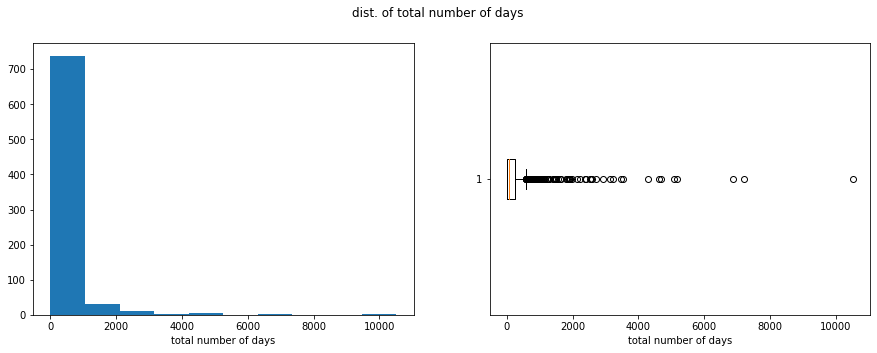

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
ax1.hist(df_artist.days)
ax1.set_xlabel("total number of days")
ax2.boxplot(df_artist.days, vert = False)
ax2.set_xlabel("total number of days")
fig.suptitle("dist. of total number of days")
plt.show()

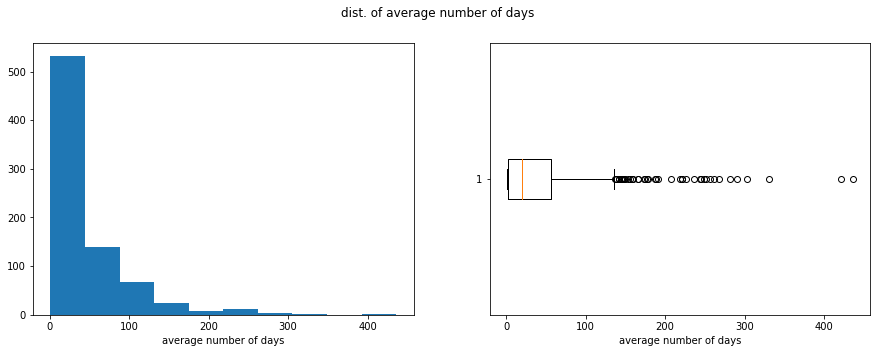

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
ax1.hist(df_artist.avg_days)
ax1.set_xlabel("average number of days")
ax2.boxplot(df_artist.avg_days, vert = False)
ax2.set_xlabel("average number of days")
fig.suptitle("dist. of average number of days")
plt.show()

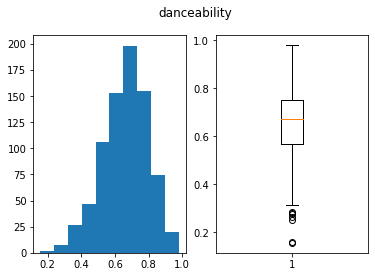

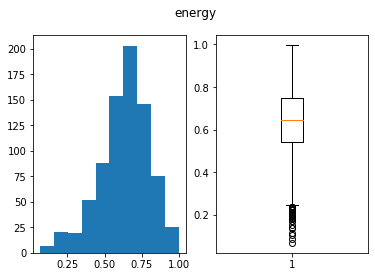

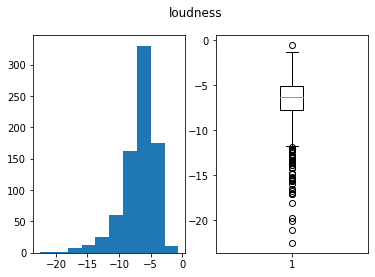

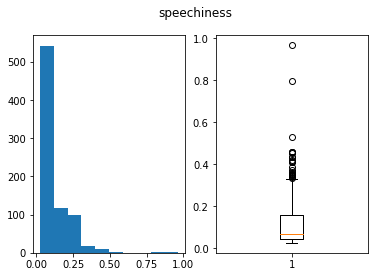

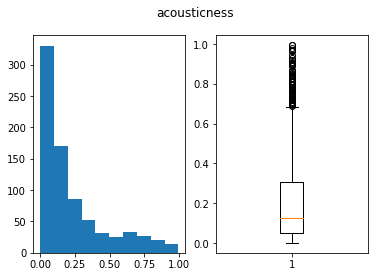

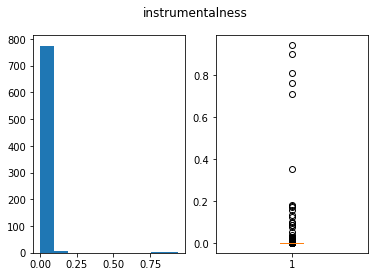

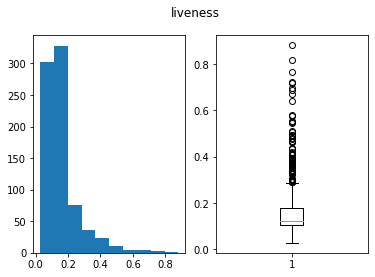

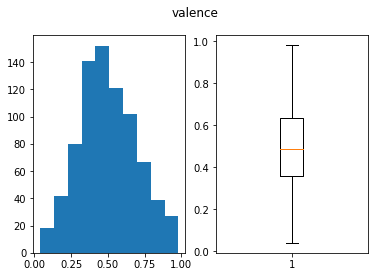

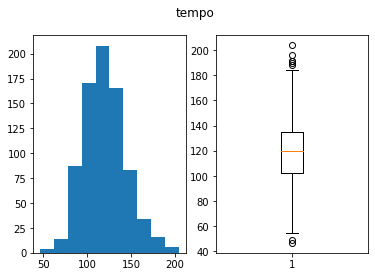

In [15]:
for k in cluster_cols:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    data = artist_dict["median_" + k]
    ax1.hist(data)
    ax2.boxplot(data)
    fig.suptitle(k)
    plt.show()

Since the majority of values for instrumentalness is 0, it won't be helpful in clustering, so it was subsequently dropped from the dataset

In [16]:
df_artist.drop(columns = ['median_instrumentalness'], inplace = True)

## Clustering artists: scaling and transforming data

Since the audio features are on difference scales (ex: tempo is usually around 100 - 150 while valence is between 0 and 1), we don't want any single feature to bias the clustering results. So, let's rescale the features.

In [26]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

In [28]:
cluster_cols = df_artist.columns[3:]
cluster_cols

Index(['median_danceability', 'median_energy', 'median_loudness',
       'median_speechiness', 'median_acousticness', 'median_liveness',
       'median_valence', 'median_tempo'],
      dtype='object')

These are the features and values to be clustered on

In [29]:
X = df_artist[cluster_cols]

In [30]:
X

median_danceability  median_energy  median_loudness  median_speechiness  \
0                 0.8365         0.6690          -5.6810             0.15400   
1                 0.7200         0.5370          -7.7055             0.17350   
2                 0.5600         0.6110          -7.0150             0.06410   
3                 0.6160         0.6285          -6.6005             0.04265   
4                 0.8030         0.6320          -5.1930             0.06490   
..                   ...            ...              ...                 ...   
784               0.5600         0.9360          -5.8350             0.04390   
785               0.5850         0.2770         -14.2310             0.03180   
786               0.6930         0.2590          -7.9180             0.03720   
787               0.5790         0.7140          -4.4550             0.03640   
788               0.8880         0.5160         -10.2280             0.41000   

     median_acousticness  median_liveness  median_valence  median_tempo  
0                0.07950           0.1325          0.3505      137.4800  
1                0.11600           0.1225          0.3525      118.9900  
2                0.13100           0.1250          0.2520      119.8290  
3                0.05865           0.1505          0.3980      104.4755  
4                0.05440           0.1110          0.2640      131.9860  
..                   ...              ...             ...           ...  
784              0.00847           0.1610          0.3710      112.9600  
785              0.67000           0.1140          0.4810      140.6660  
786              0.44800           0.0995          0.3610       88.9720  
787              0.01360           0.1110          0.3580      119.8940  
788              0.14800           0.1060          0.6060      127.8030  

[789 rows x 8 columns]

I decided to use the RobustScaler method in order to decrease the impact of outliers. The following describes how RobustScaler works:  
    Let C be the column to be rescaled and q_x be the xth quantile of C:
        For each c in C:
            c_scaled = (c - median(C))/(q_75 - q_25))

In [31]:
def scale(X):
    """
    inputs:   X: dataframe with columns of continuous features to be scaled
    
    returns:  X_scaled: dataframe with scaled columns
    """
    X_scaled = X.copy()    
    scaled_values = RobustScaler().fit_transform(X)
    
    for i in range(scaled_values.shape[1]):
        X_scaled.iloc[:,i] = scaled_values[:,i]

    return X_scaled

In [32]:
X_scaled = scale(X)
X_scaled

median_danceability  median_energy  median_loudness  median_speechiness  \
0               0.898907       0.112195         0.228545            0.763135   
1               0.262295      -0.531707        -0.531831            0.931094   
2              -0.612022      -0.170732        -0.272488           -0.011197   
3              -0.306011      -0.085366        -0.116808           -0.195952   
4               0.715847      -0.068293         0.411831           -0.004307   
..                   ...            ...              ...                 ...   
784            -0.612022       1.414634         0.170704           -0.185185   
785            -0.475410      -1.800000        -2.982723           -0.289406   
786             0.114754      -1.887805        -0.611643           -0.242894   
787            -0.508197       0.331707         0.689014           -0.249785   
788             1.180328      -0.634146        -1.479249            2.968131   

     median_acousticness  median_liveness  median_valence  median_tempo  
0              -0.187377         0.113333       -0.492806      0.545877  
1              -0.043393        -0.020000       -0.485612     -0.014315  
2               0.015779         0.013333       -0.847122      0.011104  
3              -0.269625         0.353333       -0.321942     -0.454062  
4              -0.286391        -0.173333       -0.803957      0.379425  
..                   ...              ...             ...           ...  
784            -0.467574         0.493333       -0.419065     -0.197007  
785             2.142012        -0.133333       -0.023381      0.642404  
786             1.266272        -0.326667       -0.455036     -0.923773  
787            -0.447337        -0.173333       -0.465827      0.013073  
788             0.082840        -0.240000        0.426259      0.252693  

[789 rows x 8 columns]

To help us visualize this in 2D and to prevent the curse of dimensionality from occuring, let's apply PCA to the scaled values with 2 components.

In [33]:
def apply_pca(X, n):
    pca = PCA(n_components=n)
    pc_cols = pd.DataFrame(pca.fit_transform(X), columns = [f"pc{i+1}" for i in range(n)])
    X_pca = pd.concat([X, pc_cols], axis = 1)        
    return X_pca
    

In [34]:
X_pca = apply_pca(X_scaled, 2)
X_pca.head()

median_danceability  median_energy  median_loudness  median_speechiness  \
0             0.898907       0.112195         0.228545            0.763135   
1             0.262295      -0.531707        -0.531831            0.931094   
2            -0.612022      -0.170732        -0.272488           -0.011197   
3            -0.306011      -0.085366        -0.116808           -0.195952   
4             0.715847      -0.068293         0.411831           -0.004307   

   median_acousticness  median_liveness  median_valence  median_tempo  \
0            -0.187377         0.113333       -0.492806      0.545877   
1            -0.043393        -0.020000       -0.485612     -0.014315   
2             0.015779         0.013333       -0.847122      0.011104   
3            -0.269625         0.353333       -0.321942     -0.454062   
4            -0.286391        -0.173333       -0.803957      0.379425   

        pc1       pc2  
0  0.242526 -0.918813  
1 -0.538789 -0.237923  
2 -0.464756 -0.286902  
3  0.025037 -0.333168  
4 -0.031009 -1.153019

## Clustering Artists: k-means clustering

Now that features have been scaled and PCA values have been created, we are ready to cluster artists.

In [35]:
from sklearn.cluster import KMeans

In [36]:
def choose_k(X, cols, fewest):

    df = X.loc[:,cols]
    
    ins = [] #inertias
    prev_labels = None
    min_artists = []
    k = 1
    
    while len(min_artists) == 0 or min_artists[-1] >= fewest:    
        #keep clustering while the size of the smallest cluster > specified minimum
        
        k += 1
        km = KMeans(n_clusters = k)
        km.fit(df)
        labels = pd.Series(km.labels_)
        cnt = labels.value_counts().min()


        if cnt < fewest:
            #if clustering with k clusters results in a cluster that is smaller than allowed, break out of the loop and 
            #return the data corresponding to k-1 clusters
            out = {'k':k-1, 'labels': prev_labels, 'min_artists': min_artists[-1]}
            break
        else: #update stored data, keep going
            min_artists.append(cnt)
            prev_labels = labels
            ins.append(km.inertia_)    
            
        
    xaxis = range(2, k)
    plt.plot(xaxis, ins, marker = 'x')
    plt.xticks(xaxis)
    plt.xlabel("clusters")
    plt.ylabel("inertia")
    plt.show()
    
    plt.plot(xaxis, min_artists, marker = 'x', label = 'smallest size')
    plt.plot(xaxis, np.array(min_artists)/np.array(xaxis), marker = 'o',label = 'avg size')
    plt.xticks(xaxis)
    plt.xlabel("clusters")
    plt.ylabel("cluster size")
    plt.legend()
    plt.show()
    
    return out

When running k-means clustering, you generally want to pick k to be the number of clusters corresponding to the "elbow" in the plot. By doing so, you ensure that you are not overfitting while still sufficiently reducing the within-group sum of squares.   

However, my approach for clustering in the context of this project is a bit different: since there are so many genres and subgenres that artists can fall under, I want my clustering results to capture this granularity, which is why I did not choose k to be the "elbow" of the plot. 

That being said, I did not want to have dozens of clusters containing only a few artists, so I included a parameter in the clustering function that allows the user to specify the fewest number of artists any cluster is allowed to have. So, my function increments k, runs k-means with k clusters, and checks how many artists are in the smallest cluster. It returns k and a vector of labels such that running k-means with k+1 clusters results in fewer artists than allowed.  

Since clustering is inherently random, running the function multiple times will give different results.

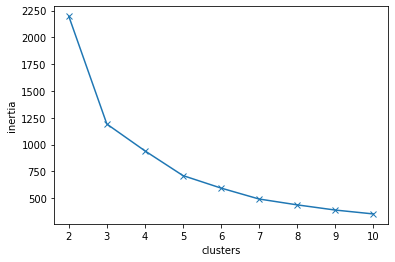

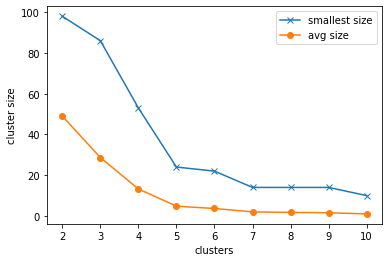

In [37]:
km_data = choose_k(X_pca, ['pc1', 'pc2'], 10)

In the above function call, I specified that the smallest cluster must have at least 10 artists (arbitrarily chosen). The first graph shows the inertia (sum of squared distances of points to their closest cluster center) for 1...k clusters, which the second graph shows the size of the smallest cluster for 1...k clusters.

In [38]:
k, labels, _ = km_data.values()

In [39]:
k #chosen k

10

In [40]:
labels.value_counts() #size of each cluster

9    197
4    163
7    103
2     98
1     67
6     62
3     37
0     31
5     21
8     10
dtype: int64

In [41]:
X_cluster = X_pca.copy()
X_cluster['cluster'] = labels

In [42]:
X_cluster

median_danceability  median_energy  median_loudness  median_speechiness  \
0               0.898907       0.112195         0.228545            0.763135   
1               0.262295      -0.531707        -0.531831            0.931094   
2              -0.612022      -0.170732        -0.272488           -0.011197   
3              -0.306011      -0.085366        -0.116808           -0.195952   
4               0.715847      -0.068293         0.411831           -0.004307   
..                   ...            ...              ...                 ...   
784            -0.612022       1.414634         0.170704           -0.185185   
785            -0.475410      -1.800000        -2.982723           -0.289406   
786             0.114754      -1.887805        -0.611643           -0.242894   
787            -0.508197       0.331707         0.689014           -0.249785   
788             1.180328      -0.634146        -1.479249            2.968131   

     median_acousticness  median_liveness  median_valence  median_tempo  \
0              -0.187377         0.113333       -0.492806      0.545877   
1              -0.043393        -0.020000       -0.485612     -0.014315   
2               0.015779         0.013333       -0.847122      0.011104   
3              -0.269625         0.353333       -0.321942     -0.454062   
4              -0.286391        -0.173333       -0.803957      0.379425   
..                   ...              ...             ...           ...   
784            -0.467574         0.493333       -0.419065     -0.197007   
785             2.142012        -0.133333       -0.023381      0.642404   
786             1.266272        -0.326667       -0.455036     -0.923773   
787            -0.447337        -0.173333       -0.465827      0.013073   
788             0.082840        -0.240000        0.426259      0.252693   

          pc1       pc2  cluster  
0    0.242526 -0.918813        4  
1   -0.538789 -0.237923        9  
2   -0.464756 -0.286902        9  
3    0.025037 -0.333168        7  
4   -0.031009 -1.153019        4  
..        ...       ...      ...  
784  0.858470 -0.868151        4  
785 -2.990849  2.207686        0  
786 -1.911167  0.562431        6  
787  0.202455 -1.276409        4  
788 -0.853297 -0.000490        2  

[789 rows x 11 columns]

Scaled values aren't easily interpretable -- let's revert back to the original values and attach the artists' labels.

In [43]:
ucl_df = pd.concat([df_artist, X_cluster.loc[:,'cluster']], axis = 1)
ucl_df.head()

artist    days   avg_days  median_danceability  median_energy  \
0             Migos  3227.0  76.833333               0.8365         0.6690   
1             Drake  6877.0  76.411111               0.7200         0.5370   
2        The Weeknd  2926.0  68.046512               0.5600         0.6110   
3  The Chainsmokers  2577.0  80.531250               0.6160         0.6285   
4      Rae Sremmurd  1147.0  76.466667               0.8030         0.6320   

   median_loudness  median_speechiness  median_acousticness  median_liveness  \
0          -5.6810             0.15400              0.07950           0.1325   
1          -7.7055             0.17350              0.11600           0.1225   
2          -7.0150             0.06410              0.13100           0.1250   
3          -6.6005             0.04265              0.05865           0.1505   
4          -5.1930             0.06490              0.05440           0.1110   

   median_valence  median_tempo  cluster  
0          0.3505      137.4800        4  
1          0.3525      118.9900        9  
2          0.2520      119.8290        9  
3          0.3980      104.4755        7  
4          0.2640      131.9860        4

In [45]:
def plot_clusters(df_labeled, k):
    for i in range(k):
        pts = df_labeled.loc[df_labeled.cluster == i, :]
        plt.scatter(pts["pc1"], pts["pc2"], label = i)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title = 'cluster',  bbox_to_anchor=(1.2, 1.0))
    plt.show()

Here's a plot showing the results of the clustering where each color represents a different cluster

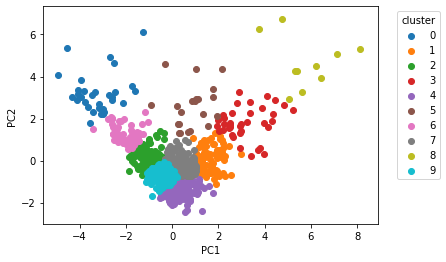

In [46]:
plot_clusters(X_cluster, k)

In [47]:
ucl_df.to_csv("data/TopCharts_clustered_artists.csv", index = False)

In [20]:
def top_artists(df, k, n, which):
    #which is either 'days' or 'average days', metric to measure popularity
    d = dict()
    for i in range(k):
        subset = df.loc[df.cluster == i, :].sort_values(by = which, ascending = False)
        d[i] = list(subset.artist[:min(n, len(subset))])
    return d

These are the top 5 most popular artists in each cluster, as determined by the total number of days their songs were on the top charts

In [23]:
pp.pprint(top_artists(ucl_df, k, 5, 'days'))

{   0: [   'Bing Crosby',
           'Frank Sinatra',
           'Nat King Cole',
           'Dean Martin',
           'Jeremy Zucker'],
    1: ['Luke Combs', 'Eminem', 'DJ Khaled', 'Panic! At The Disco', 'KYLE'],
    2: ['XXXTENTACION', 'Khalid', 'J. Cole', 'Lauv', 'Offset'],
    3: ['Lizzo', 'Famous Dex', 'Dustin Lynch', 'Lunay', 'Jaden'],
    4: ['Migos', 'Marshmello', 'Logic', 'DaBaby', '6ix9ine'],
    5: ['Lord Huron', 'Brenda Lee', 'Wham!', 'José Feliciano', 'The Jackson 5'],
    6: ['Billie Eilish', 'Sam Smith', 'Joji', '6LACK', 'Lewis Capaldi'],
    7: [   'Lil Uzi Vert',
           'Travis Scott',
           'Kendrick Lamar',
           'The Chainsmokers',
           'Future'],
    8: ['Steve Aoki', 'John Lennon', 'Powfu', 'FRENSHIP', '*NSYNC'],
    9: ['Post Malone', 'Drake', 'Juice WRLD', 'Ariana Grande', 'Ed Sheeran']}


## Clustering artists: analysis

### Representation of clusters in top 100 (most popular) artists vs bottom 100 (least popular artists)
Let's see if there are any clusters that are over/under-represented in the top 100 most popular and bottom 100 least popular artists. First, let's take a look at the raw data.

In [24]:
def plot_cluster_barchart(subset_cnts, subset_name, k, compare, all_props = None):
    
    xaxis = np.array(range(k))
    
    n = sum(subset_cnts.values)
    subset_heights = [subset_cnts[i]/n if i in subset_cnts.index else 0 for i in range(k)]
    
    plt.bar(xaxis, subset_heights, .4, label = subset_name)
    plt.xlabel("cluster")
    plt.ylabel("prop")
    if compare:
        plt.bar(xaxis+.4,all_props, .4, color='r',label='all')
        plt.legend()
        plt.xticks(xaxis+.4/2, xaxis)
    else:
        plt.xticks(xaxis)
    plt.show()
    
    return subset_heights


These are the proportions we would expect to see. For example, if we were to take a sample of 100 artists out of all artists in the dataset, we would expect ~4 of them to belong to cluster 4

In [26]:
size_all = len(df_artist)
all_cnts = ucl_df.cluster.value_counts()
print("proportion of artists in each cluster:")
for i in range(10):
    print(f"\tcluster {i}: {round(all_cnts[i]/size_all, 4)}")

proportion of artists in each cluster:
	cluster 0: 0.0393
	cluster 1: 0.0849
	cluster 2: 0.1242
	cluster 3: 0.0469
	cluster 4: 0.2066
	cluster 5: 0.0266
	cluster 6: 0.0786
	cluster 7: 0.1305
	cluster 8: 0.0127
	cluster 9: 0.2497


Distribution of clusters in entire dataset

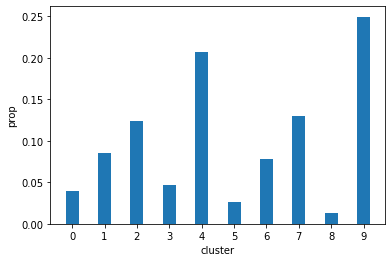

In [27]:
all_props = plot_cluster_barchart(ucl_df.cluster.value_counts(), "all", 10, False)

In [28]:
#top and bottom 100 artists by total number of days on top charts
t100 = ucl_df.sort_values(by = 'days', ascending = False).iloc[:100, :]
b100 = ucl_df.sort_values(by = 'days', ascending = True).iloc[:100, :]

Raw counts of clusters in top 100 artists. 52 of the top 100 artists are in cluster 9, 15 are in cluster 7, and so forth.

In [29]:
t100_cnts = t100.cluster.value_counts()
t100_cnts

9    52
7    15
4    13
2     9
1     5
6     4
3     2
Name: cluster, dtype: int64

Distribution of clusters proportions among top 100 artists

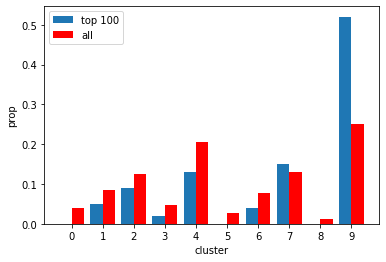

In [30]:
t100_props = plot_cluster_barchart(t100_cnts, "top 100", 10, True, all_props)

Raw counts of clusters in bottom 100 artists

In [31]:
b100_cnts = b100.cluster.value_counts()
b100_cnts

4    30
9    21
2    15
6     9
7     7
1     7
3     6
8     2
5     2
0     1
Name: cluster, dtype: int64

Distribution of clusters proportions among bottom 100 artists

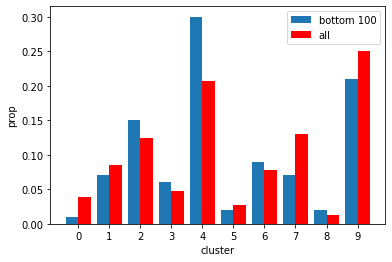

In [32]:
b100_props = plot_cluster_barchart(b100_cnts, "bottom 100", 10, True, all_props)

In the top 100 artists, it looks like cluster 9 is extremely overrepresented (with the largest absolute difference in proportions being ~0.25) while the other clusters (except for cluster 7) seem to be underrepresented. For the bottom 100 group, there doesn't seem to be significant over/underrepresentation, with the largest absolute difference in proportions being ~0.10. To validate our hypotheses, let's run 2 Chi Squared Goodness of Fit tests as formal verification.

For both groups, the hypotheses we will be testing are:
* $H_0:$ these observations are consistent with the expected distribution of cluster frequencies
* $H_1:$ these observations are NOT consistent with the expected distribution of cluster frequencies

In [33]:
from scipy.stats import chisquare

In [34]:
def gof_test(subset_cnts, all_cnts, k, verbose = True):
    
    n_sub = sum(subset_cnts.values)
    n_all = sum(all_cnts.values)
    
    observed_counts = np.array([subset_cnts[i] if i in subset_cnts.index else 0 for i in range(k)])
    expected_counts = np.array([all_cnts[i] * (n_sub/n_all) if i in all_cnts.index else 0 for i in range(k)])
    chisq, p = chisquare(observed_counts, f_exp=expected_counts)
    rej = "Yes" if p<.05 else "No"
    if verbose:
        print(f"Chisq: {chisq}\t\t Pr(>Chisq): {p}")
        print(f"Reject null?: {rej}")
    return chisq, p

In [35]:
t100_chisq, t100_p = gof_test(t100_cnts, all_cnts, 10)

Chisq: 46.06758361089492		 Pr(>Chisq): 5.850608625911187e-07
Reject null?: Yes


In [36]:
b100_chisq, b100_p = gof_test(b100_cnts, all_cnts, 10)

Chisq: 11.763425790629855		 Pr(>Chisq): 0.22697718978470988
Reject null?: No


### Conclusion: cluster representation in top/bottom 100 artists

It looks like our intuitions from looking at the distributions were correct: the distribution of cluster frequencies in the top 100 most popular artists does not match the expected frequencies. 

This means that there may be a particular audio feature (ex: valence), or a combination of features (ex: valence AND danceability) which causes the artist to be assigned to certain clusters over others. Generalizing our findings to all artists, based on these results, it is reasonable to conclude that if the artist is assigned to be in cluster 9, they are more likely to be one of the top 100 most popular artists relative to artists who are assigned to other clusters.

For the bottom 100 least popular artists, using the same logic, we can conlude that the distribution of clusters in that group is not significantly different from the overall distribution of clusters: the bottom 100 least popular artists do not have anything in particular that make them significantly any more or less likely to be assigned to a particular cluster. Therefore, we cannot conclude that an artist's cluster assignment is significantly indicative of how likely they are to be in the bottom 100 least popular artists.

However, something else to consider is how likely it is for us to have gotten our results due to sheer chance. So, let's run some simulations to see how likely or unlikely our previous results are.

### Further analysis of the goodness-of-fit test results and conclusions

In [55]:
def sim_cluster_dist(cluster_df, n_iter, k):
    sim_cnts = np.zeros(k)
    p_list = []
    chisq_list = []
    n = len(cluster_df)
    for i in range(n_iter):
        idx = np.random.choice(range(n), 100, replace = False)
        vc = cluster_df.loc[idx, 'cluster'].value_counts()
        for c in vc.index:
            sim_cnts[c] += vc[c]
        x,p = gof_test(vc, all_cnts, k, verbose = False)
        chisq_list.append(x)
        p_list.append(p)
    
    sim_props = plot_cluster_barchart(pd.Series(sim_cnts), "simulated", k, True, all_props)
    return chisq_list, p_list, sim_props

Let's run 1000 simulations of 100 random samples from the entire artist dataset.

This histogram shows the proportion of clusters across all 1000 simulations of 100 samples. We can see that it almost perfectly matches the expected proportions.

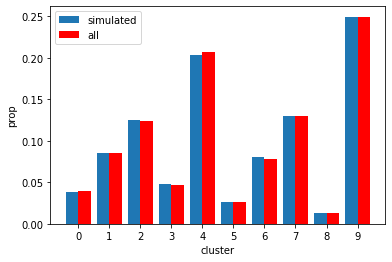

In [104]:
sim_data = sim_cluster_dist(ucl_df, 1000, 10)

We can see that 30 Type I errors (incorrectly rejecting the null hypothesis) have been made in 1000 simulations. Without even taking into considering the magnitude of our p-value for the goodness of fit test on the top 100 artists, we can see that our findings are already quite unlikely: there is only a 3% chance for our findings to have been a result of sheer chance.

In [105]:
print(f"number of times where the goodness of fit test rejects h0: {len(np.where(np.array(sim_data[1])<.05)[0])}")

number of times where the goodness of fit test rejects h0: 30


Now, let's take into consideration the magnitude of our findings by looking at the distribution of $\chi^2$ statistics in the simulation

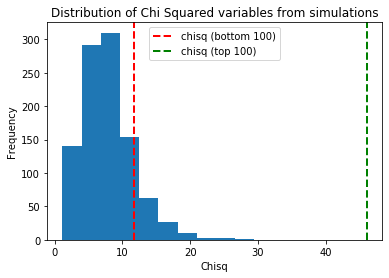

In [103]:
plt.hist(sim_data[0])
plt.axvline(x=b100_chisq, color='r', linestyle='dashed', linewidth=2, label = "chisq (bottom 100)")
plt.axvline(x =t100_chisq, color = 'g', linestyle = 'dashed', linewidth = 2, label = 'chisq (top 100)')
plt.title("Distribution of Chi Squared variables from simulations")
plt.xlabel("Chisq")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [106]:
print(f"number of simulated chisq variable > chisq variable for bottom 100: {len(np.where(np.array(sim_data[0])>b100_chisq)[0])}")
print(f"number of simulated chisq variable > chisq variable for top 100: {len(np.where(np.array(sim_data[0])>t100_chisq)[0])}")

number of simulated chisq variable > chisq variable for bottom 100: 144
number of simulated chisq variable > chisq variable for top 100: 0


This histogram shows the distribution of $\chi^2$ statistics from the simulation (for example, there are ~300 simulated $\chi^2$ variables around 10). In the above output, we can see the number of times where the simulation produced results as extreme or even more extreme than we results we observed for the bottom and top 100 artists. Since there are 144 $\chi^2$ variables greater than our observed $\chi^2$ variable for the bottom 100 artists, we can conclude that the differences between the distributions of clusters in the bottom 100 artists and the overall dataset is insignificant (we fail to reject the null hypothesis). On the other hand, not a single simulation in the 1000 simulations we ran produced results remotely close to the $\chi^2$ statistic we observed for the top 100 artists. This means that it is extremely unlikely for our findings to be an artifact of randomness -- the differences between the distributions of clusters in the top 100 artists and the overall dataset is very significant.